In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geojson
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

#from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from descartes import PolygonPatch
from haversine import haversine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans

from collections import Counter

import os
%matplotlib inline
from IPython.display import display

pd.set_option('display.max_columns', 500)

## Loading Data Sets

In [24]:
nyc_taxi_trip_duration_dir="../../../datasets/nyc_taxi_trip_duration"
nyc_taxi_with_osrm_dir="../../../datasets/nyc_taxi_with_osrm"

#### kaggle datasets

In [25]:
from subprocess import check_output
print(check_output(["ls", nyc_taxi_trip_duration_dir]).decode("utf8"))
print ''
print(check_output(["ls", nyc_taxi_with_osrm_dir]).decode("utf8"))

NYC_2016Holidays.csv
community-districts-polygon.geojson
sample_submission.csv
test.csv
train.csv
weather_data_nyc_centralpark_2016.csv


accidents_2016.csv
fastest_routes_test.csv
fastest_routes_train_part_1.csv
fastest_routes_train_part_2.csv
second_fastest_routes_test.csv
second_fastest_routes_train.csv
test.csv
train.csv



In [26]:
kaggle_df=pd.read_csv(os.path.join(nyc_taxi_trip_duration_dir,'train.csv'))

#change datetime variable type
kaggle_df['pickup_datetime']  = pd.to_datetime(kaggle_df['pickup_datetime'])
kaggle_df['dropoff_datetime'] = pd.to_datetime(kaggle_df['dropoff_datetime'])

display(kaggle_df.head(2))
print kaggle_df.shape
print kaggle_df.info()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663


(1458644, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB
None


In [27]:
display(kaggle_df.describe())

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


#### NYC_2016Holidays

In [28]:
holidays_df=pd.read_csv(os.path.join(nyc_taxi_trip_duration_dir,'NYC_2016Holidays.csv'),
              sep=';')

holidays_df['Date'] = holidays_df['Date'].apply(lambda x: x + ' 2016')
holidays_df['Date']  = pd.to_datetime(holidays_df['Date'])

display(holidays_df.head(2))
print holidays_df.shape

,Day,Date,Holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day


(15, 3)


#### NYC_2016weather

In [29]:
weather_df=pd.read_csv(os.path.join(nyc_taxi_trip_duration_dir,'weather_data_nyc_centralpark_2016.csv'))
weather_df['date']  = pd.to_datetime(weather_df['date'])

display(weather_df.head(2))
print weather_df.shape
print weather_df.info()

,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,44,34,39.0,0,0,0
1,2016-02-01,40,30,35.0,0,0,0


(366, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
date                   366 non-null datetime64[ns]
maximum temerature     366 non-null int64
minimum temperature    366 non-null int64
average temperature    366 non-null float64
precipitation          366 non-null object
snow fall              366 non-null object
snow depth             366 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 20.1+ KB
None


In [30]:
#convert the traces (T) values into small numeric amounts
weather_df = weather_df.replace(to_replace='T', value=0.01)
#convert columns that accept this value into numeric ones
weather_df['precipitation'] = pd.to_numeric(weather_df['precipitation'])
weather_df['snow fall'] = pd.to_numeric(weather_df['snow fall'])
weather_df['snow depth'] = pd.to_numeric(weather_df['snow depth'])

In [31]:
display(weather_df.describe())

,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
count,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000
mean,63.385246,48.275956,55.830601,0.112978,0.081749,0.237896
std,17.901150,17.281008,17.388234,0.280316,0.704652,1.132686
min,14.000000,-6.000000,4.000000,0.000000,0.000000,0.000000
25%,49.250000,36.000000,42.500000,0.000000,0.000000,0.000000
50%,63.000000,47.000000,54.250000,0.000000,0.000000,0.000000
75%,80.000000,64.000000,72.000000,0.040000,0.000000,0.000000
max,96.000000,81.000000,88.500000,2.200000,9.500000,10.000000


## Feature Engineering

#### 1 create pickup_cluster feature

In [32]:
coords=np.vstack((kaggle_df[['pickup_latitude',  'pickup_longitude']].values,
                  kaggle_df[['dropoff_latitude',  'dropoff_longitude']].values,
                  kaggle_df[['pickup_latitude',  'pickup_longitude']].values,
                  kaggle_df[['pickup_latitude',  'pickup_longitude']].values))
kmeans=MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords)

coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ..., 
       [ 40.76879883, -73.95912933],
       [ 40.74906158, -73.98207855],
       [ 40.78174973, -73.97953796]])

In [33]:
kaggle_df['pickup_cluster']  = kmeans.predict(kaggle_df[['pickup_latitude', 'pickup_longitude']])
kaggle_df['dropoff_cluster'] = kmeans.predict(kaggle_df[['dropoff_latitude', 'dropoff_longitude']])

display(kaggle_df.head(2))
print kaggle_df.shape

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,18,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,26,54


(1458644, 13)


#### 2 haversine_distance feature

In [34]:
kaggle_df['haversine_distance'] = kaggle_df.apply(lambda x: haversine((x['pickup_latitude'],  x['pickup_longitude']), 
                                                                      (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)

In [35]:
print('Mean trip distance (km): {0:.2f}'.format(kaggle_df['haversine_distance'].mean()))
print('Max trip distance (km) {0:.2f}'.format(kaggle_df['haversine_distance'].max()))
print('Min trip distance (km) {0:.2f}'.format(kaggle_df['haversine_distance'].min()))
print('Median trip distance (km): {0:.2f}'.format(kaggle_df['haversine_distance'].median()))

Mean trip distance (km): 3.44
Max trip distance (km) 1240.91
Min trip distance (km) 0.00
Median trip distance (km): 2.09


#### 3 create date, weekday, hour, month, day

In [36]:
kaggle_df['pickup_date'] = pd.to_datetime(kaggle_df['pickup_datetime'].dt.date)
kaggle_df['pickup_weekday'] = kaggle_df['pickup_datetime'].dt.weekday
kaggle_df['pickup_hour'] = kaggle_df['pickup_datetime'].dt.hour
kaggle_df['pickup_month'] = kaggle_df['pickup_datetime'].dt.month
kaggle_df['pickup_day'] = kaggle_df['pickup_datetime'].dt.day

In [37]:
display(kaggle_df.head(2))
print kaggle_df.shape

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,haversine_distance,pickup_date,pickup_weekday,pickup_hour,pickup_month,pickup_day
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,18,3,1.498521,2016-03-14,0,17,3,14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,26,54,1.805507,2016-06-12,6,0,6,12


(1458644, 19)


####  4 merge weather df & add 7 weather features

In [38]:
kaggle_df2 = kaggle_df.merge(weather_df, left_on='pickup_date', right_on='date', how='inner')

display(kaggle_df2.head(2))
print kaggle_df2.shape

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,haversine_distance,pickup_date,pickup_weekday,pickup_hour,pickup_month,pickup_day,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,18,3,1.498521,2016-03-14,0,17,3,14,2016-03-14,48,42,45.0,0.89,0.0,0.0
1,id2129090,1,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,N,1346,45,53,1.972206,2016-03-14,0,14,3,14,2016-03-14,48,42,45.0,0.89,0.0,0.0


(1458644, 26)


In [39]:

# create temperature_class feature
temperature_class=[]
for temp in kaggle_df2['average temperature']:
    if temp<20:
        temperature_class.append('0-20')
    elif temp<30:
        temperature_class.append('20-30')
    elif temp<40:
        temperature_class.append('30-40')
    elif temp<50:
        temperature_class.append('40-50')
    elif temp<60:
        temperature_class.append('50-60')
    elif temp<70:
        temperature_class.append('60-70')
    else:
        temperature_class.append('70+')
kaggle_df2['temperature_class']=temperature_class
print Counter(temperature_class)

Counter({'40-50': 329447, '70+': 311791, '50-60': 261965, '30-40': 222695, '60-70': 205413, '20-30': 94214, '0-20': 33119})


In [40]:
le = LabelEncoder()
for feature in ['store_and_fwd_flag', 'vendor_id']:
    kaggle_df2[feature] = le.fit_transform(kaggle_df2[feature])
    print feature,': [0,1] =',le.classes_
display(kaggle_df2.head(2))


store_and_fwd_flag : [0,1] = ['N' 'Y']
vendor_id : [0,1] = [1 2]


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,haversine_distance,pickup_date,pickup_weekday,pickup_hour,pickup_month,pickup_day,date,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth,temperature_class
0,id2875421,1,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,18,3,1.498521,2016-03-14,0,17,3,14,2016-03-14,48,42,45.0,0.89,0.0,0.0,40-50
1,id2129090,0,2016-03-14 14:05:39,2016-03-14 14:28:05,1,-73.975090,40.758766,-73.953201,40.765068,0,1346,45,53,1.972206,2016-03-14,0,14,3,14,2016-03-14,48,42,45.0,0.89,0.0,0.0,40-50


## Data Cleaning

In [41]:
def clean_data(df):
    df = df.copy()
    df = df[(df['trip_duration'] > 60*1) & (df['trip_duration'] < 3600 * 12)] # Trip duration filtering
    df = df[(df['haversine_distance'] > 0.01)&(df['haversine_distance'] < 400)] # Distance filtering
    df = df[(df['passenger_count'] > 0)]
    return df

kaggle_df3=clean_data(kaggle_df2)

print 'Delete {} variables'.format(kaggle_df2.shape[0]-kaggle_df3.shape[0])

Delete 15602 variables


In [42]:
kaggle_df3.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_cluster,dropoff_cluster,haversine_distance,pickup_weekday,pickup_hour,pickup_month,pickup_day,maximum temerature,minimum temperature,average temperature,precipitation,snow fall,snow depth
count,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06,1.443042e+06
mean,5.344529e-01,1.664958e+00,-7.397368e+01,4.075099e+01,-7.397359e+01,4.075188e+01,5.455836e-03,8.442510e+02,4.742239e+01,4.847854e+01,3.468269e+00,3.049477e+00,1.361227e+01,3.516645e+00,1.550419e+01,5.976825e+01,4.438833e+01,5.207829e+01,9.354899e-02,7.639943e-02,2.654360e-01
std,4.988118e-01,1.314139e+00,6.849132e-02,2.914714e-02,6.739942e-02,3.372571e-02,7.366188e-02,6.962644e+02,2.852276e+01,2.862772e+01,3.986778e+00,1.953837e+00,6.396646e+00,1.680920e+00,8.703312e+00,1.641048e+01,1.622397e+01,1.606439e+01,2.258006e-01,6.753015e-01,1.195238e+00
min,0.000000e+00,1.000000e+00,-1.219333e+02,3.471223e+01,-1.219333e+02,3.218114e+01,0.000000e+00,6.100000e+01,0.000000e+00,0.000000e+00,1.008889e-02,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.400000e+01,-6.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,-7.399187e+01,4.073742e+01,-7.399133e+01,4.073596e+01,0.000000e+00,4.020000e+02,2.200000e+01,2.300000e+01,1.251989e+00,1.000000e+00,9.000000e+00,2.000000e+00,8.000000e+00,4.700000e+01,3.300000e+01,4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00,-7.398177e+01,4.075414e+01,-7.397978e+01,4.075457e+01,0.000000e+00,6.660000e+02,4.900000e+01,5.000000e+01,2.113977e+00,3.000000e+00,1.400000e+01,4.000000e+00,1.500000e+01,5.900000e+01,4.300000e+01,5.050000e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,2.000000e+00,-7.396748e+01,4.076836e+01,-7.396315e+01,4.076983e+01,0.000000e+00,1.077000e+03,6.900000e+01,7.200000e+01,3.903945e+00,5.000000e+00,1.900000e+01,5.000000e+00,2.300000e+01,7.400000e+01,6.000000e+01,6.650000e+01,4.000000e-02,0.000000e+00,0.000000e+00
max,1.000000e+00,8.000000e+00,-6.697216e+01,4.437194e+01,-6.904802e+01,4.314758e+01,1.000000e+00,4.317700e+04,9.900000e+01,9.900000e+01,3.201258e+02,6.000000e+00,2.300000e+01,6.000000e+00,3.100000e+01,9.100000e+01,7.500000e+01,8.300000e+01,1.240000e+00,9.500000e+00,1.000000e+01


In [43]:
kaggle_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443042 entries, 0 to 1458643
Data columns (total 27 columns):
id                     1443042 non-null object
vendor_id              1443042 non-null int64
pickup_datetime        1443042 non-null datetime64[ns]
dropoff_datetime       1443042 non-null datetime64[ns]
passenger_count        1443042 non-null int64
pickup_longitude       1443042 non-null float64
pickup_latitude        1443042 non-null float64
dropoff_longitude      1443042 non-null float64
dropoff_latitude       1443042 non-null float64
store_and_fwd_flag     1443042 non-null int64
trip_duration          1443042 non-null int64
pickup_cluster         1443042 non-null int32
dropoff_cluster        1443042 non-null int32
haversine_distance     1443042 non-null float64
pickup_date            1443042 non-null datetime64[ns]
pickup_weekday         1443042 non-null int64
pickup_hour            1443042 non-null int64
pickup_month           1443042 non-null int64
pickup_day           

In [44]:
kaggle_df3.to_csv('../../../datasets/nyc_taxi_trip_duration/df_after_preprocess.csv')

## Visualization

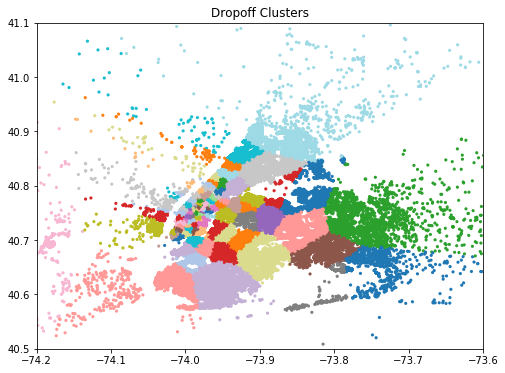

In [22]:
#dropoff_cluster
fig = plt.figure(figsize=(8,6))
ax = fig.gca() 

ax.scatter(kaggle_df3['dropoff_longitude'].values, 
           kaggle_df3['dropoff_latitude'].values, 
           s=10, lw=0,
           c=kaggle_df3['dropoff_cluster'].values, 
           cmap='tab20', zorder=2)

plt.title('Dropoff Clusters')
plt.ylim(40.5,41.1)
plt.xlim(-74.2,-73.6)
plt.show()

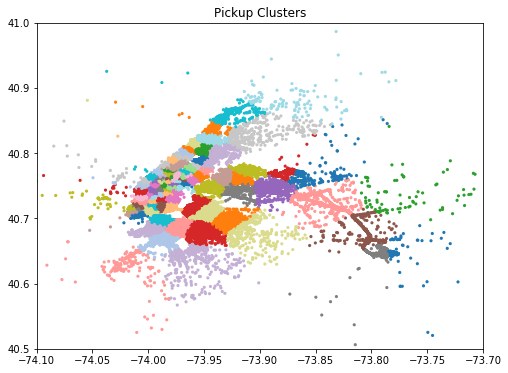

In [23]:
#pickup_cluster
fig = plt.figure(figsize=(8,6))
ax = fig.gca() 

ax.scatter(kaggle_df3['pickup_longitude'].values, 
           kaggle_df3['pickup_latitude'].values, 
           s=10, lw=0,
           c=kaggle_df3['pickup_cluster'].values, 
           cmap='tab20', zorder=2)

plt.title('Pickup Clusters')
plt.ylim(40.5,41)
plt.xlim(-74.1,-73.7)
plt.show()

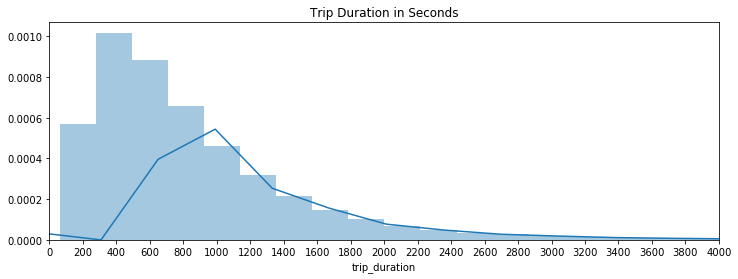

Mean trip duration : 14.07 min
Max trip duration : 719.00 min
Min trip duration : 1.00 min
Median trip duration : 11.10 min


In [24]:
#duration distribution
plt.figure(figsize=(12, 4))
plt.title('Trip Duration in Seconds')
sns.distplot(kaggle_df3['trip_duration'],
             hist=True,
             bins=200)
plt.xlim(0,4000)
plt.xticks(np.linspace(0,4000,21))
plt.show()

print('Mean trip duration : {0:.2f} min'.format(kaggle_df3['trip_duration'].mean()/60))
print('Max trip duration : {0:.2f} min'.format(kaggle_df3['trip_duration'].max()/60))
print('Min trip duration : {0:.2f} min'.format(kaggle_df3['trip_duration'].min()/60))
print('Median trip duration : {0:.2f} min'.format(kaggle_df3['trip_duration'].median()/60))

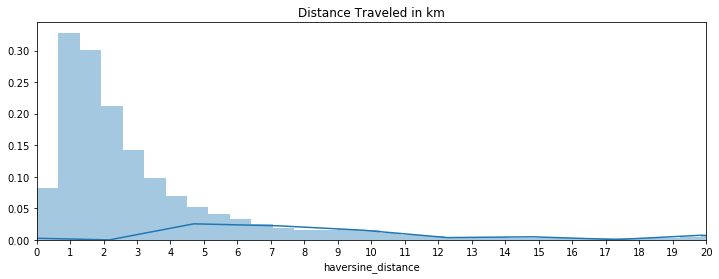

Mean trip distance (km): 3.47
Max trip distance (km) 320.13
Median trip distance (km): 2.11


In [25]:
#distance distribution

plt.figure(figsize=(12, 4))
plt.title('Distance Traveled in km')
sns.distplot(kaggle_df3['haversine_distance'], 
             hist=True,
             bins=500)
plt.xlim(0,20)
plt.xticks( range(21) )
plt.show()

print('Mean trip distance (km): {0:.2f}'.format(kaggle_df3['haversine_distance'].mean()))
print('Max trip distance (km) {0:.2f}'.format(kaggle_df3['haversine_distance'].max()))
print('Median trip distance (km): {0:.2f}'.format(kaggle_df3['haversine_distance'].median()))

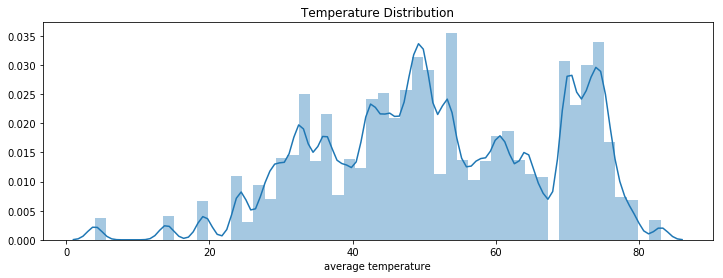

In [26]:
plt.figure(figsize=(12, 4))
plt.title('Temperature Distribution')
sns.distplot(kaggle_df3['average temperature'], 
             hist=True)
#plt.xlim(0,20)
#plt.xticks( range(21) )
plt.show()

#### categorical features

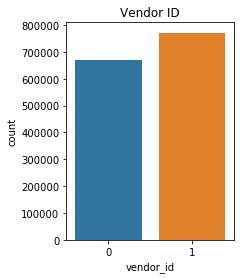

In [27]:
plt.figure(figsize=(3, 4))
plt.title('Vendor ID')
sns.countplot(x='vendor_id', data=kaggle_df3)
plt.show()

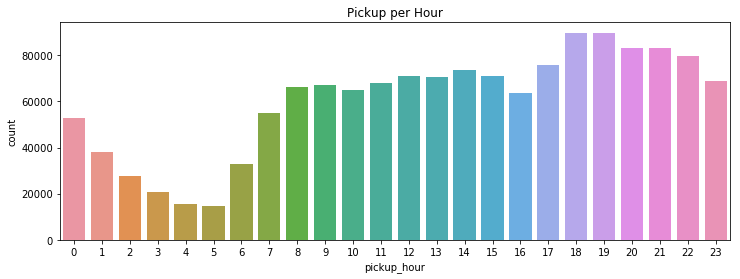

In [28]:
plt.figure(figsize=(12, 4))
plt.title('Pickup per Hour')
sns.countplot(x='pickup_hour', data=kaggle_df3)
plt.show()

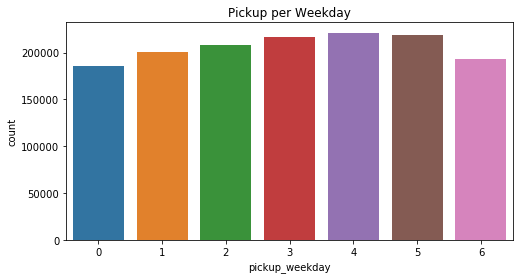

In [29]:
plt.figure(figsize=(8, 4))
plt.title('Pickup per Weekday')
sns.countplot(x='pickup_weekday', data=kaggle_df3)
plt.show()

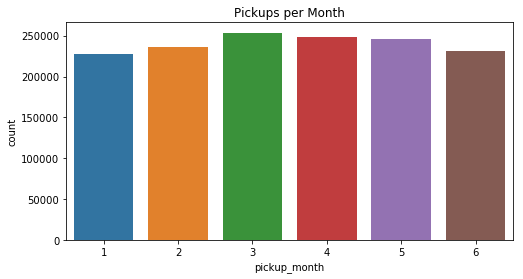

In [30]:
plt.figure(figsize=(8, 4))
plt.title('Pickups per Month')
sns.countplot(x='pickup_month', data=kaggle_df3)
plt.show()

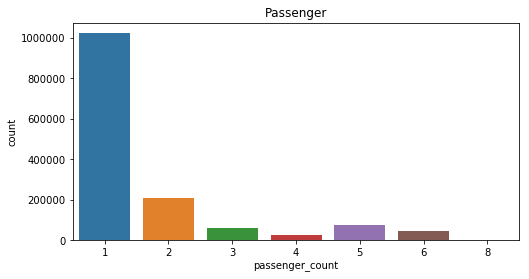

In [31]:
plt.figure(figsize=(8,4))
plt.title('Passenger')
sns.countplot(x='passenger_count', data=kaggle_df3)
plt.show()

#### numeric feature duration by categorical features

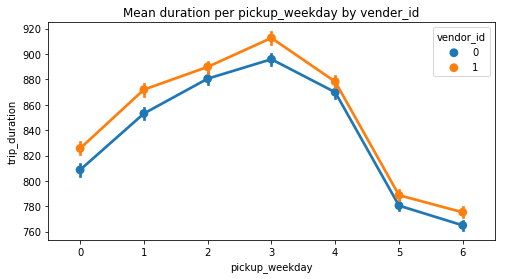

In [32]:
plt.figure(figsize=(8,4))
plt.title('Mean duration per pickup_weekday by vender_id')
sns.pointplot(x='pickup_weekday', 
               y='trip_duration',
               hue='vendor_id',
               data=kaggle_df3)
plt.show()

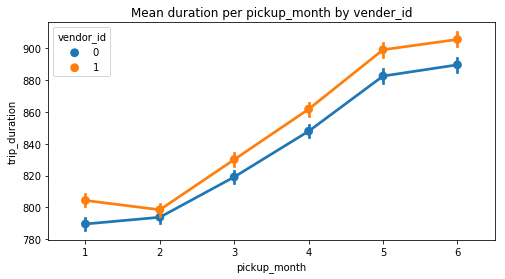

In [33]:
plt.figure(figsize=(8,4))
plt.title('Mean duration per pickup_month by vender_id')
sns.pointplot(x='pickup_month', 
               y='trip_duration',
               hue='vendor_id',
               data=kaggle_df3)
plt.show()

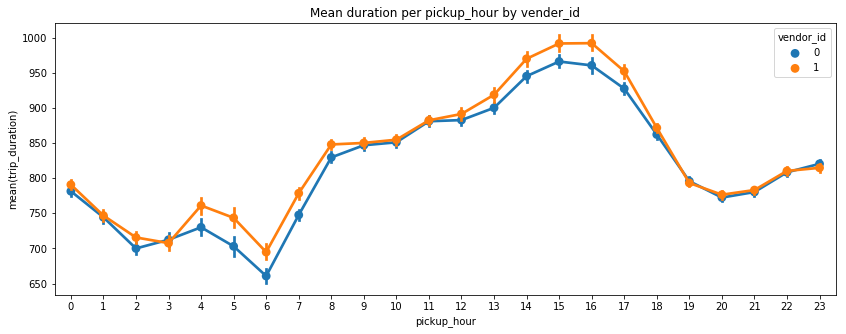

In [34]:
plt.figure(figsize=(14,5))
plt.title('Mean duration per pickup_hour by vender_id')
sns.pointplot(x='pickup_hour', 
               y='trip_duration',
               hue='vendor_id',
               data=kaggle_df3)

plt.ylabel('mean(trip_duration)')
plt.show()

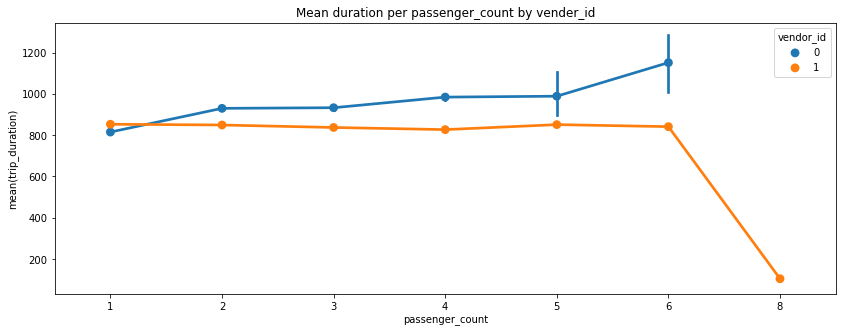

In [35]:
plt.figure(figsize=(14,5))
plt.title('Mean duration per passenger_count by vender_id')
sns.pointplot(x='passenger_count', 
               y='trip_duration',
               hue='vendor_id',
               data=kaggle_df3)

plt.ylabel('mean(trip_duration)')
plt.show()

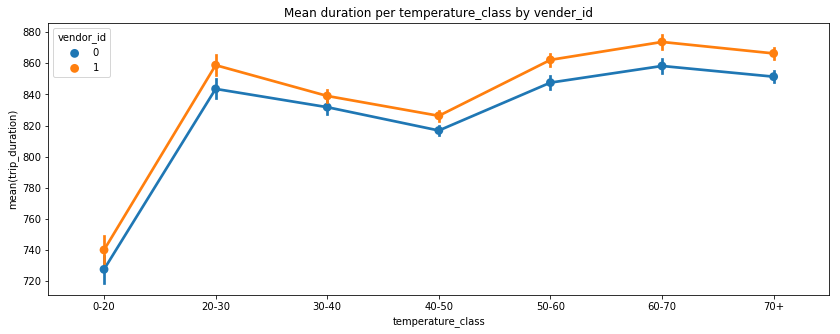

In [36]:
order=['0-20','20-30','30-40','40-50','50-60','60-70','70+']

plt.figure(figsize=(14,5))
plt.title('Mean duration per temperature_class by vender_id')
sns.pointplot(x='temperature_class', 
               y='trip_duration',
               hue='vendor_id',
               order=order,
               data=kaggle_df3)

plt.ylabel('mean(trip_duration)')
plt.show()